In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set()

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

%matplotlib inline

## 正则化的线性回归 —— 岭回归与Lasso回归
前面使用多项式回归，如果多项式最高次项比较大，模型就容易出现过拟合。正则化是一种常见的防止过拟合的方法，一般原理是在代价函数后面加上一个对参数的约束项，这个约束项被叫做正则化项（regularizer）。在线性回归模型中，通常有两种不同的正则化项：

* 加上所有参数（不包括θ0）的绝对值之和，即l1范数，此时叫做Lasso回归；  
* 加上所有参数（不包括θ0）的平方和，即l2范数，此时叫做岭回归.

## 数据

下是使用的数据是使用y=x^2 + 2并加入一些随机误差生成的，只取了10个数据点：

In [17]:
data = np.array([[ -2.95507616,  10.94533252],
       [ -0.44226119,   2.96705822],
       [ -2.13294087,   6.57336839],
       [  1.84990823,   5.44244467],
       [  0.35139795,   2.83533936],
       [ -1.77443098,   5.6800407 ],
       [ -1.8657203 ,   6.34470814],
       [  1.61526823,   4.77833358],
       [ -2.38043687,   8.51887713],
       [ -1.40513866,   4.18262786]])

X = data[:, 0].reshape(-1, 1)  # 将array转换成矩阵
y = data[:, 1]
X.shape, y.shape

((10, 1), (10,))

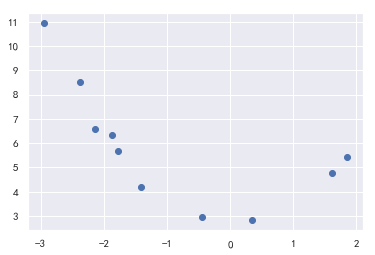

In [18]:
plt.scatter(X[:,0], y)

## 手写岭回归

![](assets/2020-05-07_222828.jpg)

<div style="color:#FF0000;font-weight:900;font-size:20px">
可以看到也就是比普通的线性回归多了后面的求导，直接加过来就行，
需要注意的是θ中不包含截距，带截距时，为了方便计算，向量最前面多加一个0就行。
</div>

![](assets/2020-05-07_223714.jpg)
![](assets/2020-05-07_223934.jpg)

In [185]:
# 和MyLinearRegression的区别就在求梯度的函数地方,还有就是多了一个lamb惩罚系数
class MyRidge():
    def __init__(self, fit_intercept=True ):
        self.fit_intercept = fit_intercept
        
        self.intercept_ = None
        self.coef_ = []
        
    def fit(self, X, y, alpha = 0.01, lamb=0.1,max_iters = 100000, c = 0.001, debug_cost=True):
        self.alpha = alpha #学习率
        self.max_iters = max_iters
        self.c = c #两次结果之差小于这个值就停止迭代
        self.lamb = lamb # lamb
        
        if self.fit_intercept:
            theta = np.full(X.shape[1]+1, 1)#权重向量，带截距
            X = np.hstack([np.ones((X.shape[0],1)), X])
        else:
            theta = np.full(X.shape[1], 1)#权重向量，不带截距
            X = X.copy()
            
        
        num_iters = 0
        preCost = 0
        while(True): 
            gradient = self.get_gradient(X, y, theta)
            theta = theta - gradient * alpha
            cost = self.computer_cost(X,y,theta)    
            if(num_iters != 0 and (preCost - cost < c or num_iters > max_iters) ):
                break
            if debug_cost and num_iters % 1000 == 0 :       
                print("cost:%f" % cost)
            preCost = cost
            num_iters += 1           
            
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = None
            self.coef_ = theta[:]
            
        #if debug_cost:
        print("final cost:%f" % cost)
        
    
    def get_gradient(self, X, y, theta):
        h_y = (np.dot(X, theta) - y)
        #np.dot(h_y.reshape(1, -1), X) / X.shape[0]
        # 把矩阵放到左边省的再把向量转换成矩阵，麻烦
        # 不带正则的：np.dot(X.T, h_y) / X.shape[0]
        #print("lamb:"+str(self.lamb))
        if self.lamb == 0:
            return np.dot(X.T, h_y) / X.shape[0]
        if self.fit_intercept:
            return np.dot(X.T, h_y) / X.shape[0] + self.lamb * np.r_[ np.array([0]), theta[1:] ]
        else:
            return np.dot(X.T, h_y) / X.shape[0] + self.lamb * theta
    
    # 计算代价函数
    def computer_cost(self, X,y,theta):    
        return ( (np.dot(X, theta) - y) ** 2 ).mean()/2
    
    def score(self, X_train, y):
        y_predict = np.dot(X_train, self.coef_) +  self.intercept_ if self.fit_intercept else 0
        u = ( (y - y_predict)**2 ).sum()
        v = ( (y - y.mean())** 2).sum()
        return 1 - u/v

In [15]:
# 一维数组也可以连接
n1 = np.array([0])
n2 = np.array([1,2,3,4])
np.hstack([n1,n2]), np.r_[n1,n2]

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [21]:
# 重新赋值吧
# 这样切片[:,:-1]取出的数据维度就不会减少
X = data[:,:-1]
y = data[:,-1]

X.shape, y.shape

((10, 1), (10,))

In [23]:
# 用于生成多项式特征的
from sklearn.preprocessing import PolynomialFeatures

In [35]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

my_ridge = MyRidge(fit_intercept=True)
my_ridge.fit(X_poly, y, c=0.00001)

print("score:%.2f" % my_ridge.score(X_poly, y))

my_ridge.intercept_, my_ridge.coef_

cost:3.070310
final cost:0.036775
score:0.99


(2.5355082094729386, array([-0.12725372,  0.92431495]))

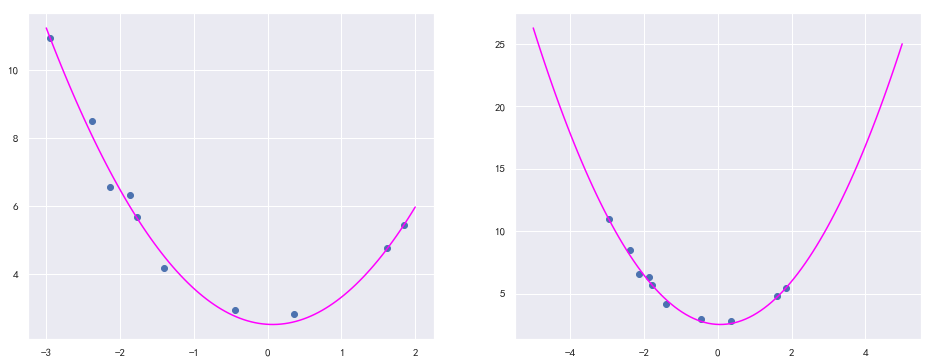

In [36]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

ax = axs[0]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-3, 2, 100)
# poly_features.fit_transform必须传入2维的矩阵
line_y = np.dot(poly_features.fit_transform(line_x.reshape(-1,1)), my_ridge.coef_) + my_ridge.intercept_
ax.plot(line_x, line_y, color="#ff00ff")

ax = axs[1]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-5, 5, 100)
# poly_features.fit_transform必须传入2维的矩阵
line_y = np.dot(poly_features.fit_transform(line_x.reshape(-1,1)), my_ridge.coef_) + my_ridge.intercept_
ax.plot(line_x, line_y, color="#ff00ff")

**看看幂增大时，过拟合的情况**

In [64]:
degree = 4
poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
X_poly_d = poly_features_d.fit_transform(X)

my_ridge_d = MyRidge(fit_intercept=True)
my_ridge_d.fit(X_poly_d, y, alpha=0.001, c=0.00001, lamb=0.1)
intercept_,coef_ = my_ridge_d.intercept_, my_ridge_d.coef_

print("score:%.2f" % my_ridge_d.score(X_poly_d, y))

print("intercept:%.2f; coef_:%s" % ( intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]" ) )

cost:21.151394
cost:0.169545
cost:0.115221
cost:0.085820
cost:0.066456
cost:0.053721
final cost:0.053257
score:0.98
intercept:2.22; coef_:[0.1241, 1.1155, -0.0756, -0.0332]


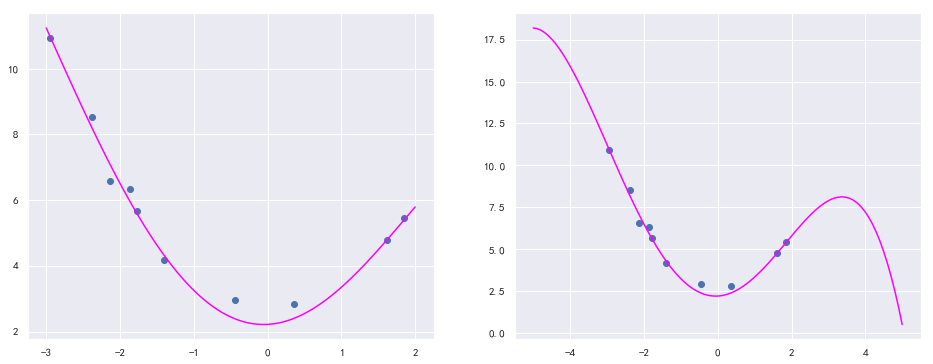

In [55]:
fig, axs = plt.subplots(1,2, figsize=(16,6))

ax = axs[0]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-3, 2, 100)
line_y = np.dot(poly_features_d.fit_transform(line_x.reshape(-1,1)), coef_) + intercept_
ax.plot(line_x, line_y, color="#ff00ff")

ax = axs[1]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-5, 5, 100)
line_y = np.dot(poly_features_d.fit_transform(line_x.reshape(-1,1)),coef_) + intercept_
ax.plot(line_x, line_y, color="#ff00ff")

cost:21.120564
cost:0.196871
cost:0.115164
cost:0.081309
cost:0.065011
final cost:0.064311
score:0.98
intercept:2.45; coef_:[-0.1113, 0.8181, 0.003, 0.0192]


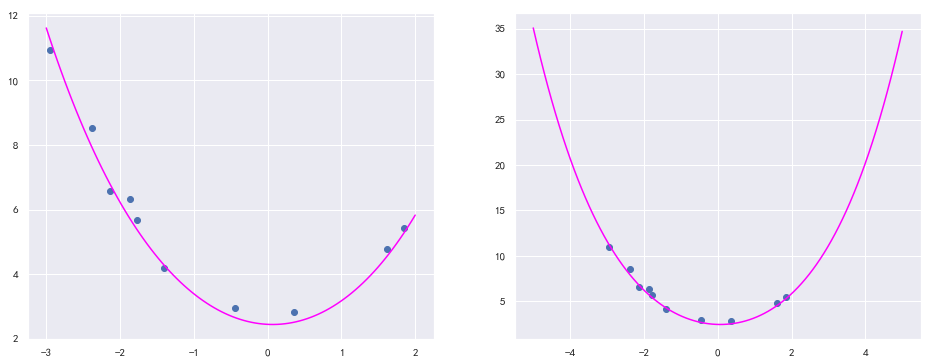

In [65]:
degree = 4
poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
X_poly_d = poly_features_d.fit_transform(X)

my_ridge_d = MyRidge(fit_intercept=True)
my_ridge_d.fit(X_poly_d, y, alpha=0.001, c=0.00001, lamb=0.5)
intercept_,coef_ = my_ridge_d.intercept_, my_ridge_d.coef_

print("score:%.2f" % my_ridge_d.score(X_poly_d, y))
print("intercept:%.2f; coef_:%s" % ( intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]" ) )


fig, axs = plt.subplots(1,2, figsize=(16,6))

ax = axs[0]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-3, 2, 100)
line_y = np.dot(poly_features_d.fit_transform(line_x.reshape(-1,1)), coef_) + intercept_
ax.plot(line_x, line_y, color="#ff00ff")

ax = axs[1]
# 数据集
ax.scatter(X[:,0], y)
# 预测的曲线
line_x = np.linspace(-5, 5, 100)
line_y = np.dot(poly_features_d.fit_transform(line_x.reshape(-1,1)),coef_) + intercept_
ax.plot(line_x, line_y, color="#ff00ff")

In [110]:
from sklearn.preprocessing import StandardScaler

In [62]:
# lamb=0.1 时的截距与权重：intercept:2.22; coef_:[0.1241, 1.1155, -0.0756, -0.0332]
# lamb=0.5 时的截距与权重：intercept:2.45; coef_:[-0.1113, 0.8181, 0.003, 0.0192]

final cost:0.294759
final cost:0.243394
final cost:0.189993
final cost:0.294759
final cost:0.243394
final cost:0.189993


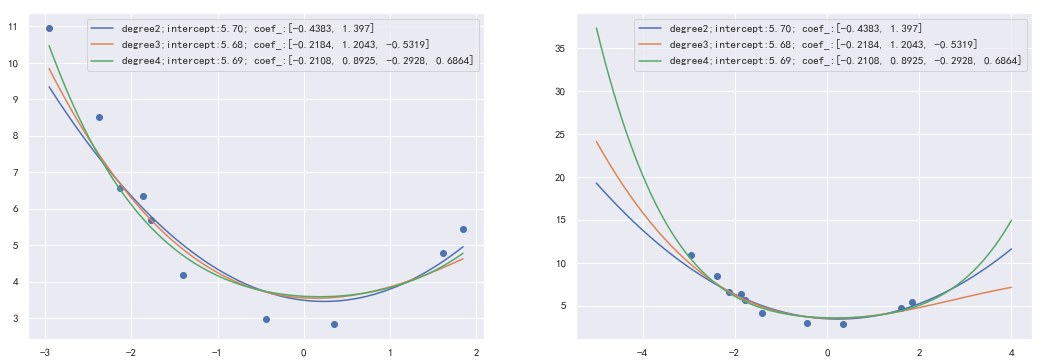

In [111]:
def show_ridge_fig(ax, X, y,min_degree, max_degree, alpha=0.001, c=0.00001, lamb=0.5, max_iters= 100000, line_range=None):
    if line_range is None:
        line_range = (X.min(), X.max())
    
    # 数据集
    ax.scatter(X[:,0], y)
    
    legends = []
    for degree in range(min_degree, max_degree + 1):
        poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
        X_poly_d = poly_features_d.fit_transform(X)
        
        #数太大了，不然学习率梯度下降不好求
        std = StandardScaler()
        X_poly_d = std.fit_transform(X_poly_d)

        my_ridge_d = MyRidge(fit_intercept=True)
        my_ridge_d.fit(X_poly_d, y, alpha=alpha, c=c, lamb=lamb, max_iters=max_iters,debug_cost=False)
        intercept_,coef_ = my_ridge_d.intercept_, my_ridge_d.coef_

       
        # 预测的曲线
        line_x = np.linspace(line_range[0], line_range[1], 100)
        line_X = poly_features_d.fit_transform(line_x.reshape(-1,1))
        line_X = std.transform(line_X)
        line_y = np.dot(line_X, coef_) + intercept_
        ax.plot(line_x, line_y)
        legends.append( "degree%d;intercept:%.2f; coef_:%s" % (degree, 
            intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]"  ) )
        ax.legend(legends)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
show_ridge_fig(ax[0], X, y, 2, 4)
show_ridge_fig(ax[1], X, y, 2, 4, line_range=(-5, 4))

final cost:0.069043
final cost:0.077680


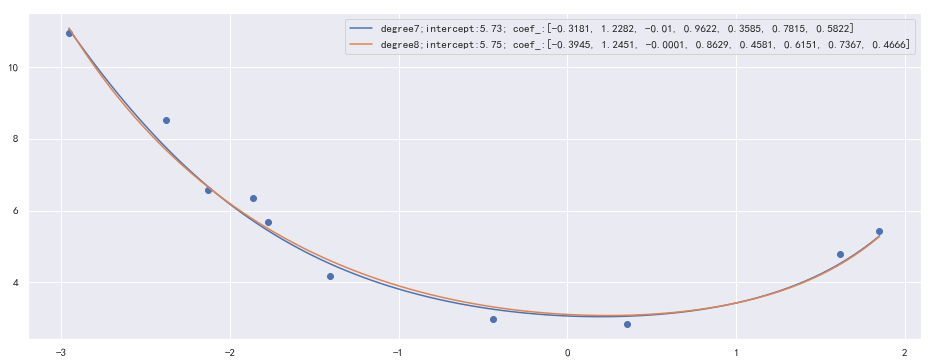

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
show_ridge_fig(ax, X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.1)

final cost:0.215563
final cost:0.227167
final cost:0.043270
final cost:0.050336


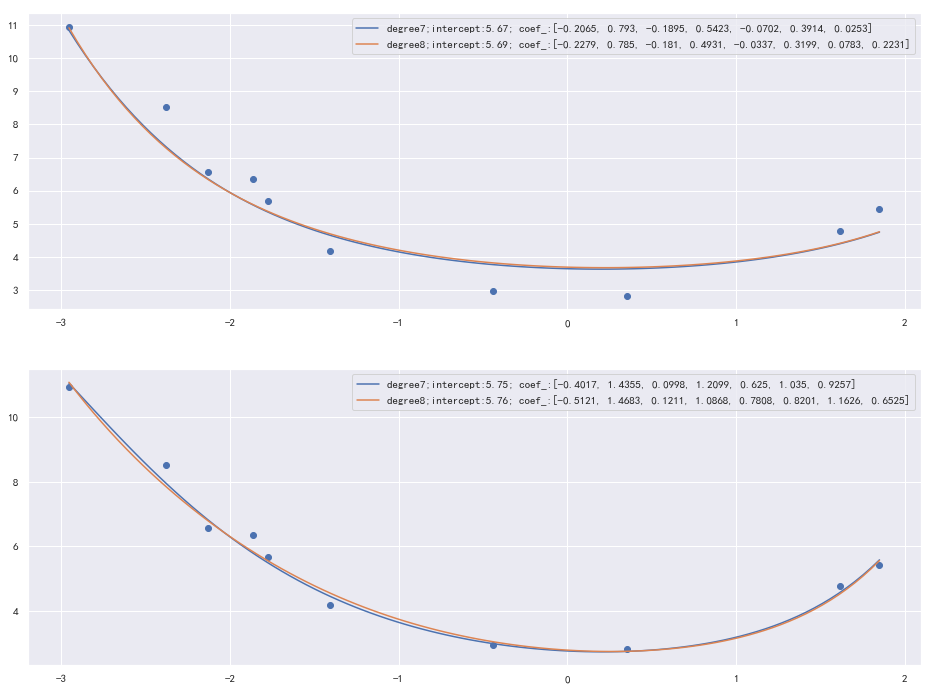

In [127]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))
show_ridge_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.5)

show_ridge_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0)

final cost:0.357126
final cost:0.361244
final cost:0.044528
final cost:0.038681


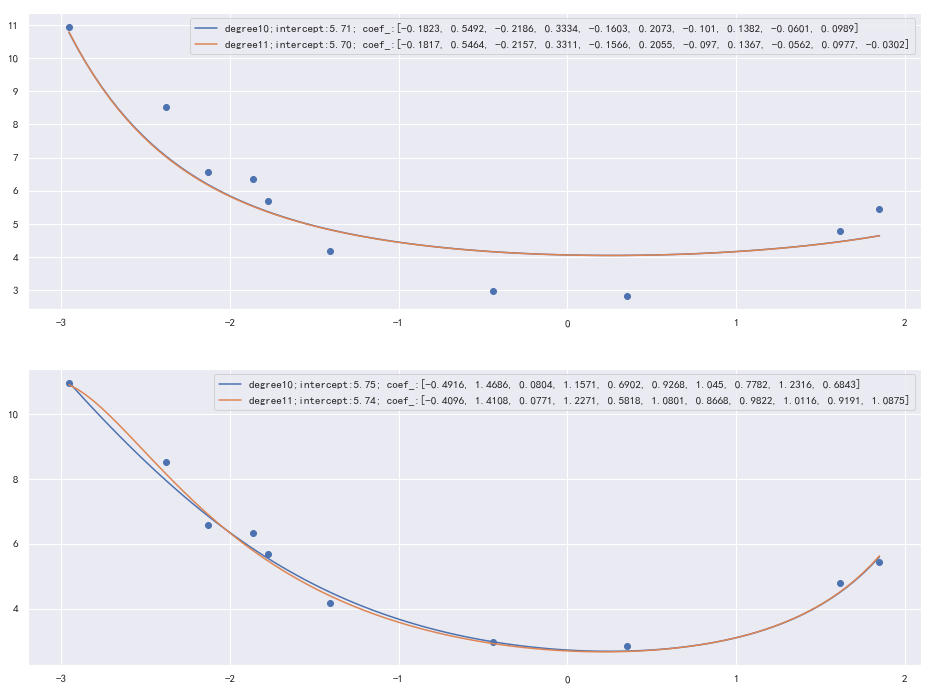

In [132]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))
show_ridge_fig(ax[0], X, y, 10, 11, alpha=0.001, max_iters=1000000,lamb=1)

show_ridge_fig(ax[1], X, y, 10, 11, alpha=0.001, max_iters=1000000,lamb=0)

## sklearn

In [133]:
from sklearn.linear_model import Ridge

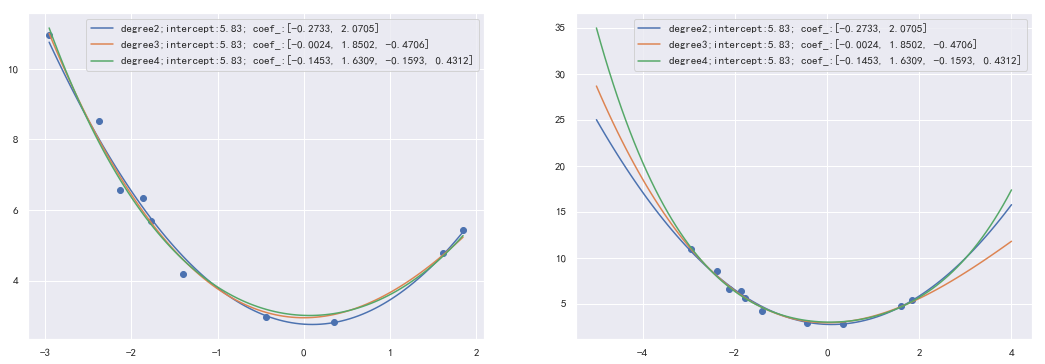

In [149]:
def show_ridge_fig_sklearn(ax, X, y,min_degree, max_degree, alpha=0.001, c=0.00001, lamb=0.5, max_iters= 100000,
                           solver='auto',line_range=None):
    if line_range is None:
        line_range = (X.min(), X.max())
    
    # 数据集
    ax.scatter(X[:,0], y)
    
    legends = []
    for degree in range(min_degree, max_degree + 1):
        poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
        X_poly_d = poly_features_d.fit_transform(X)
        
        #数太大了，不然学习率梯度下降不好求
        std = StandardScaler()
        X_poly_d = std.fit_transform(X_poly_d)

        ridge_d = Ridge(alpha=lamb, solver=solver)
        ridge_d.fit(X_poly_d, y)
        intercept_,coef_ = ridge_d.intercept_, ridge_d.coef_

       
        # 预测的曲线
        line_x = np.linspace(line_range[0], line_range[1], 100)
        line_X = poly_features_d.fit_transform(line_x.reshape(-1,1))
        line_X = std.transform(line_X)
        line_y = np.dot(line_X, coef_) + intercept_
        ax.plot(line_x, line_y)
        legends.append( "degree%d;intercept:%.2f; coef_:%s" % (degree, 
            intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]"  ) )
        ax.legend(legends)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
show_ridge_fig_sklearn(ax[0], X, y, 2, 4)
show_ridge_fig_sklearn(ax[1], X, y, 2, 4, line_range=(-5, 4))

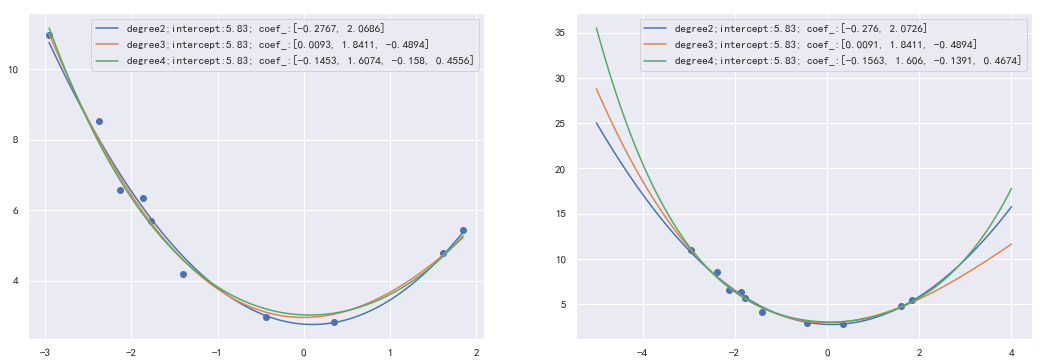

In [154]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
show_ridge_fig_sklearn(ax[0], X, y, 2, 4, solver='sag')
show_ridge_fig_sklearn(ax[1], X, y, 2, 4, line_range=(-5, 4), solver='sag')

final cost:0.294759
final cost:0.243394
final cost:0.189993
final cost:0.294759
final cost:0.243394
final cost:0.189993


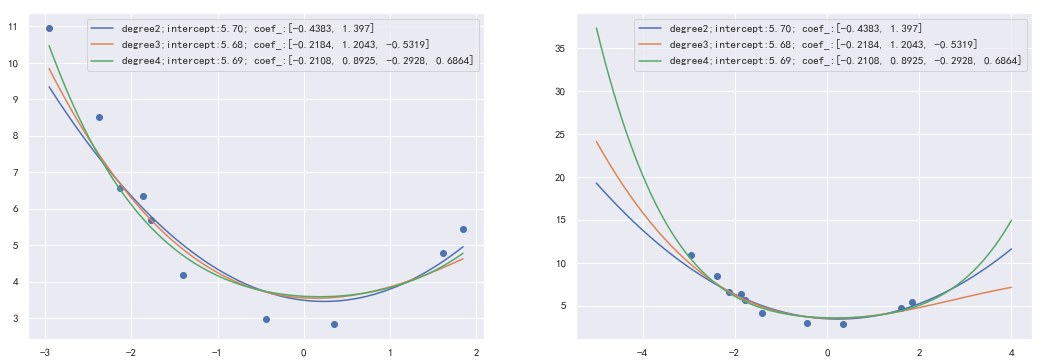

In [155]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
show_ridge_fig(ax[0], X, y, 2, 4, alpha=0.001,lamb=0.5)
show_ridge_fig(ax[1], X, y, 2, 4, alpha=0.001,lamb=0.5, line_range=(-5, 4))

final cost:0.228773
final cost:0.223959


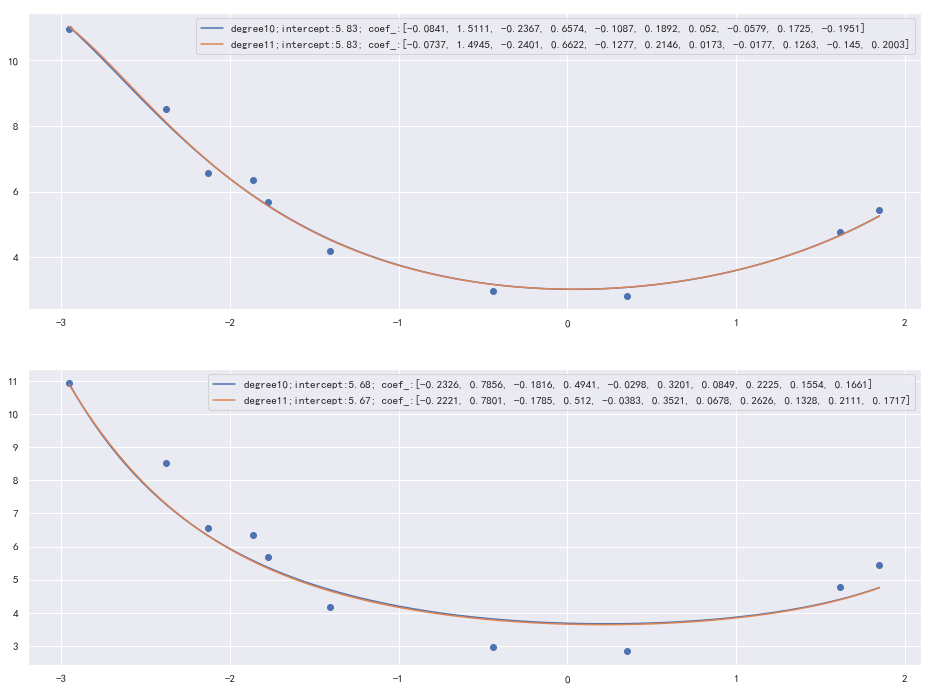

In [163]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

# 自己实现的和sklearn的计算出来有点差别
show_ridge_fig_sklearn(ax[0], X, y, 10, 11, solver='sag')

show_ridge_fig(ax[1], X, y, 10, 11, alpha=0.001, max_iters=1000000,lamb=0.5)

In [164]:
from sklearn.linear_model import LinearRegression

In [166]:
def show_linear_fig_sklearn(ax, X, y,min_degree, max_degree, alpha=0.001, c=0.00001, lamb=0.5, max_iters= 100000,
                            line_range=None):
    if line_range is None:
        line_range = (X.min(), X.max())
    
    # 数据集
    ax.scatter(X[:,0], y)
    
    legends = []
    for degree in range(min_degree, max_degree + 1):
        poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
        X_poly_d = poly_features_d.fit_transform(X)
        
        #数太大了，不然学习率梯度下降不好求
        std = StandardScaler()
        X_poly_d = std.fit_transform(X_poly_d)

        ridge_d = LinearRegression()
        ridge_d.fit(X_poly_d, y)
        intercept_,coef_ = ridge_d.intercept_, ridge_d.coef_

       
        # 预测的曲线
        line_x = np.linspace(line_range[0], line_range[1], 100)
        line_X = poly_features_d.fit_transform(line_x.reshape(-1,1))
        line_X = std.transform(line_X)
        line_y = np.dot(line_X, coef_) + intercept_
        ax.plot(line_x, line_y)
        legends.append( "degree%d;intercept:%.2f; coef_:%s" % (degree, 
            intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]"  ) )
        ax.legend(legends)

final cost:0.044528
final cost:0.038681


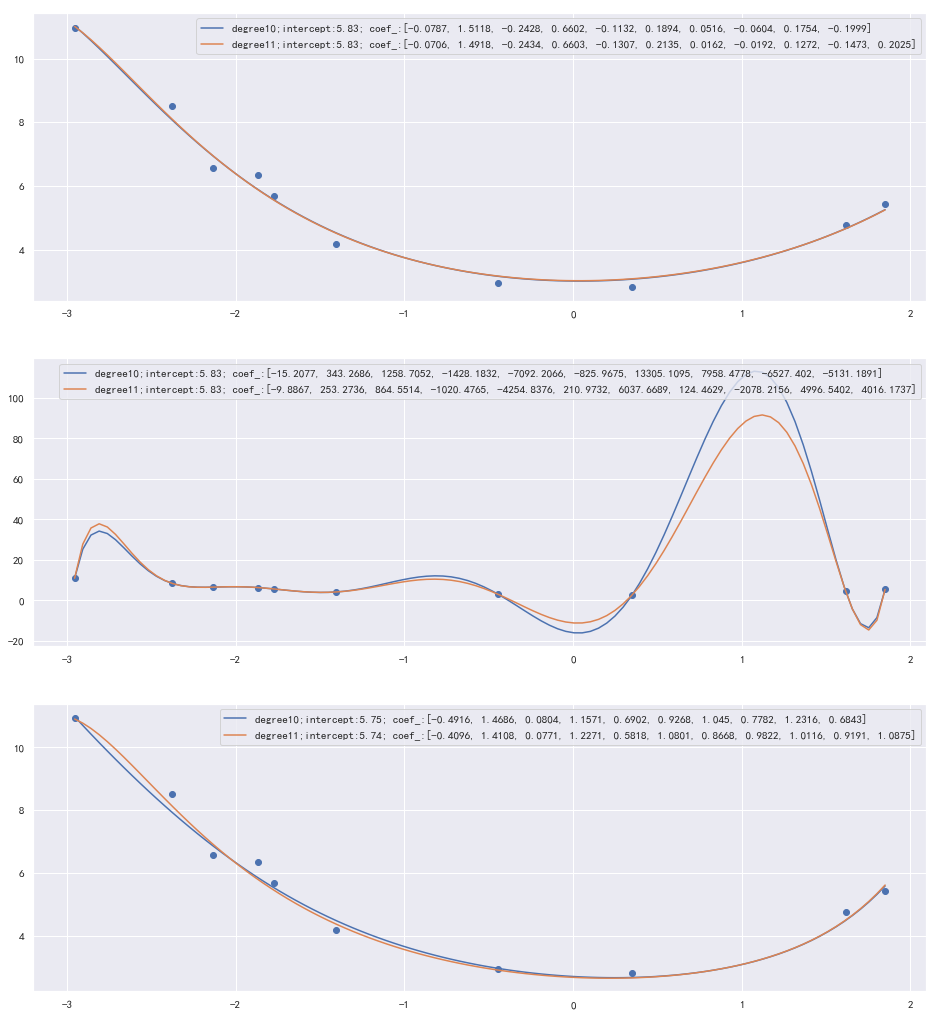

In [186]:
fig, ax = plt.subplots(3, 1, figsize=(16, 6 * 3))

# 看来我自己写的还是有点用的，直接使用线性回归参数这么大
show_ridge_fig_sklearn(ax[0], X, y, 10, 11, solver='sag')

show_linear_fig_sklearn(ax[1], X, y, 10, 11)

show_ridge_fig(ax[2], X, y, 10, 11, alpha=0.001, max_iters=1000000,lamb=0)

## 手写Lasso

Lasso回归的代价函数为：
![](assets/2020-05-08_013035.jpg)
![](assets/2020-05-08_012354.jpg)

![](assets/2020-05-08_012520.jpg)

In [190]:
# 和MyLinearRegression的区别就在求梯度的函数地方,还有就是多了一个lamb惩罚系数
class MyLasso():
    def __init__(self, fit_intercept=True ):
        self.fit_intercept = fit_intercept
        
        self.intercept_ = None
        self.coef_ = []
        
    def fit(self, X, y, alpha = 0.01, lamb=0.1,max_iters = 100000, c = 0.001, debug_cost=True):
        self.alpha = alpha #学习率
        self.max_iters = max_iters
        self.c = c #两次结果之差小于这个值就停止迭代
        self.lamb = lamb # lamb
        
        if self.fit_intercept:
            theta = np.full(X.shape[1]+1, 1)#权重向量，带截距
            X = np.hstack([np.ones((X.shape[0],1)), X])
        else:
            theta = np.full(X.shape[1], 1)#权重向量，不带截距
            X = X.copy()
            
        
        num_iters = 0
        preCost = 0
        while(True): 
            gradient = self.get_gradient(X, y, theta)
            theta = theta - gradient * alpha
            cost = self.computer_cost(X,y,theta)    
            if(num_iters != 0 and (preCost - cost < c or num_iters > max_iters) ):
                break
            if debug_cost and num_iters % 1000 == 0 :       
                print("cost:%f" % cost)
            preCost = cost
            num_iters += 1           
            
        if self.fit_intercept:
            self.intercept_ = theta[0]
            self.coef_ = theta[1:]
        else:
            self.intercept_ = None
            self.coef_ = theta[:]
            
        #if debug_cost:
        print("final cost:%f" % cost)
        
    
    def get_gradient(self, X, y, theta):
        h_y = (np.dot(X, theta) - y)
        #np.dot(h_y.reshape(1, -1), X) / X.shape[0]
        # 把矩阵放到左边省的再把向量转换成矩阵，麻烦
        # 不带正则的：np.dot(X.T, h_y) / X.shape[0]
        if self.fit_intercept:
            return np.dot(X.T, h_y) / X.shape[0] + self.lamb * np.r_[ np.array([0]), self.my_where(theta[1:]) ]
        else:
            return np.dot(X.T, h_y) / X.shape[0] + self.lamb * self.my_where(theta)
    
    # 计算代价函数
    def computer_cost(self, X,y,theta):    
        return ( (np.dot(X, theta) - y) ** 2 ).mean()/2
    
    def score(self, X_train, y):
        y_predict = np.dot(X_train, self.coef_) +  self.intercept_ if self.fit_intercept else 0
        u = ( (y - y_predict)**2 ).sum()
        v = ( (y - y.mean())** 2).sum()
        return 1 - u/v
    
    def my_where(self, array):
        array = np.where(array>0, 1, array)
        array = np.where(array<0, -1, array)
        return array

In [170]:
np.where(np.array([1,-1,2,3,-4,-3,0,3])>=0, 1, -1)

array([ 1, -1,  1,  1, -1, -1,  1,  1])

In [172]:
def my_where(array):
    array = np.where(array>0, 1, array)
    array = np.where(array<0, -1, array)
    return array

my_where( np.array([1,-1,2,3,-4,-3,0,3]) )

array([ 1, -1,  1,  1, -1, -1,  0,  1])

final cost:0.662668
final cost:0.692286
final cost:0.767565
final cost:0.662668
final cost:0.692286
final cost:0.767565


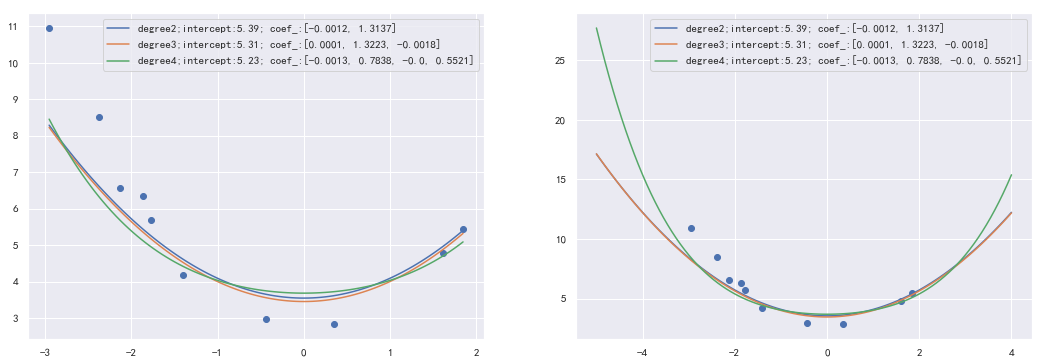

In [177]:
def show_lasso_fig(ax, X, y,min_degree, max_degree, alpha=0.001, c=0.00001, lamb=0.5, max_iters= 100000, line_range=None):
    if line_range is None:
        line_range = (X.min(), X.max())
    
    # 数据集
    ax.scatter(X[:,0], y)
    
    legends = []
    for degree in range(min_degree, max_degree + 1):
        poly_features_d = PolynomialFeatures(degree = degree, include_bias=False)
        X_poly_d = poly_features_d.fit_transform(X)
        
        #数太大了，不然学习率梯度下降不好求
        std = StandardScaler()
        X_poly_d = std.fit_transform(X_poly_d)

        my_lasso_d = MyLasso(fit_intercept=True)
        my_lasso_d.fit(X_poly_d, y, alpha=alpha, c=c, lamb=lamb, max_iters=max_iters,debug_cost=False)
        intercept_,coef_ = my_lasso_d.intercept_, my_lasso_d.coef_

       
        # 预测的曲线
        line_x = np.linspace(line_range[0], line_range[1], 100)
        line_X = poly_features_d.fit_transform(line_x.reshape(-1,1))
        line_X = std.transform(line_X)
        line_y = np.dot(line_X, coef_) + intercept_
        ax.plot(line_x, line_y)
        legends.append( "degree%d;intercept:%.2f; coef_:%s" % (degree, 
            intercept_, "["+ ", ".join(np.round(coef_,4).astype("str"))+"]"  ) )
        ax.legend(legends)

fig, ax = plt.subplots(1, 2, figsize=(18, 6))
show_lasso_fig(ax[0], X, y, 2, 4, lamb=1)
show_lasso_fig(ax[1], X, y, 2, 4, lamb=1 , line_range=(-5, 4))

final cost:0.962403
final cost:0.923127
final cost:0.043270
final cost:0.050336


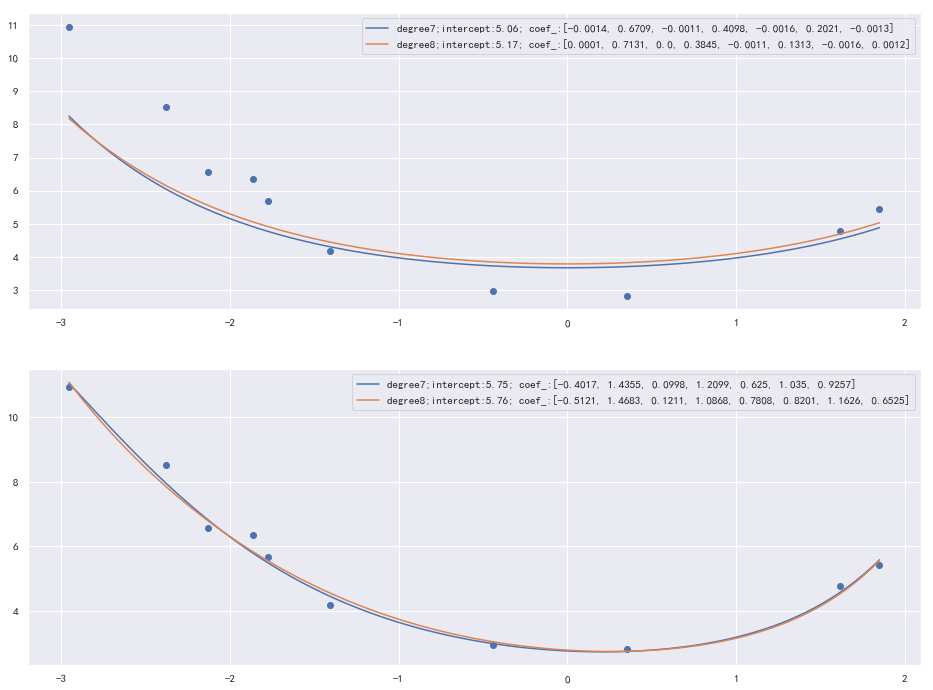

In [192]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

# 权重较小的原因是由于初始化的时候为1
show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=1)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0)

final cost:0.327307
final cost:0.303461
final cost:0.962403
final cost:0.923127


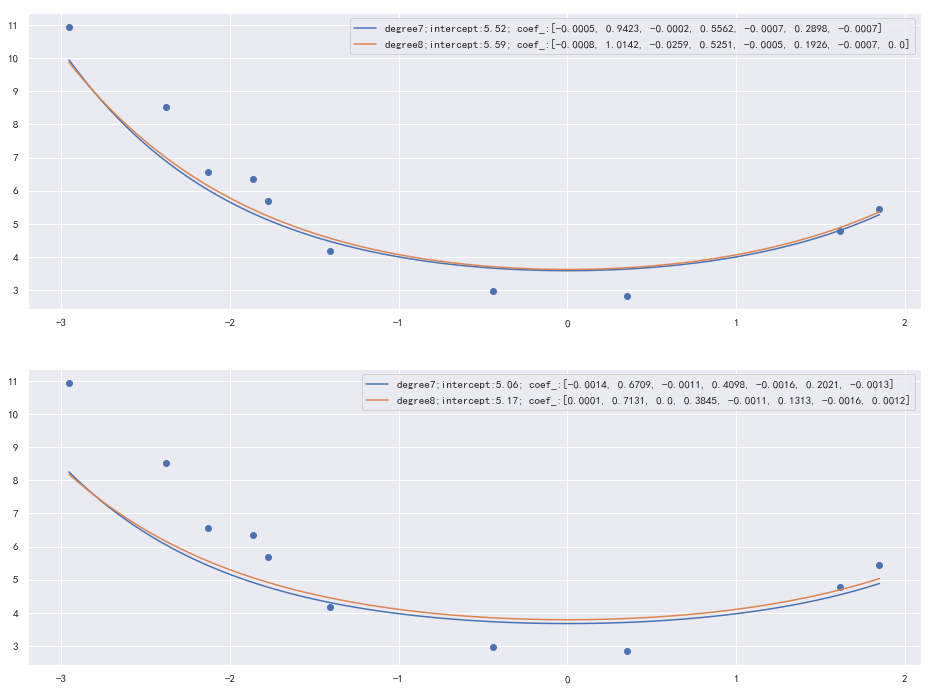

In [193]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

# 权重较小的原因是由于初始化的时候为1
show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.5)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=1)

final cost:0.145555
final cost:0.138818
final cost:0.327307
final cost:0.303461


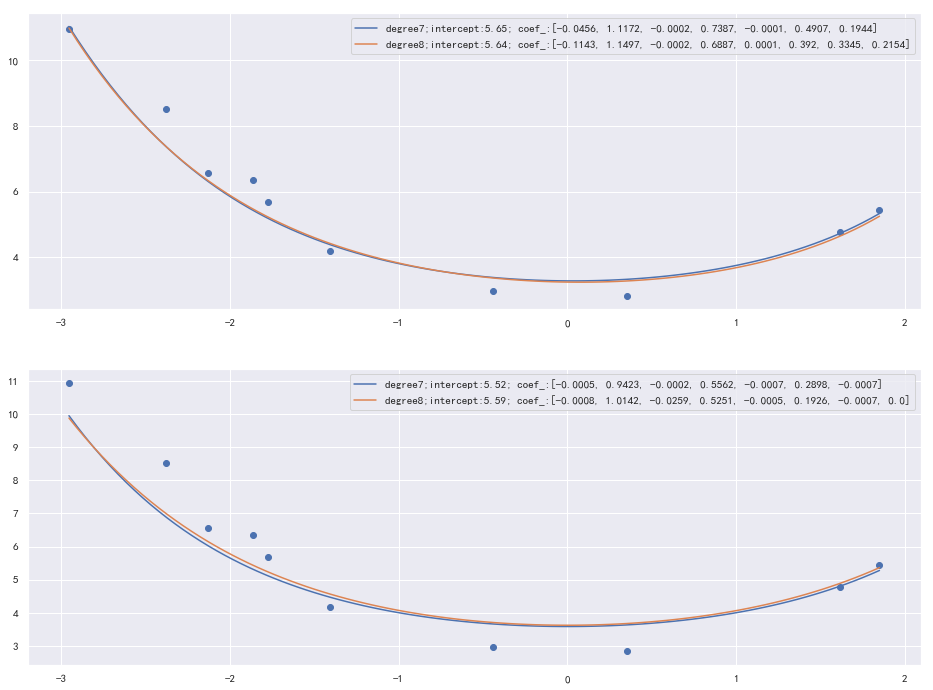

In [197]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

# 权重较小的原因是由于初始化的时候为1
show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.2)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.5)

final cost:0.145555
final cost:0.138818
final cost:0.202043
final cost:0.218435
final cost:0.140074
final cost:0.119034
final cost:0.183384
final cost:0.218435


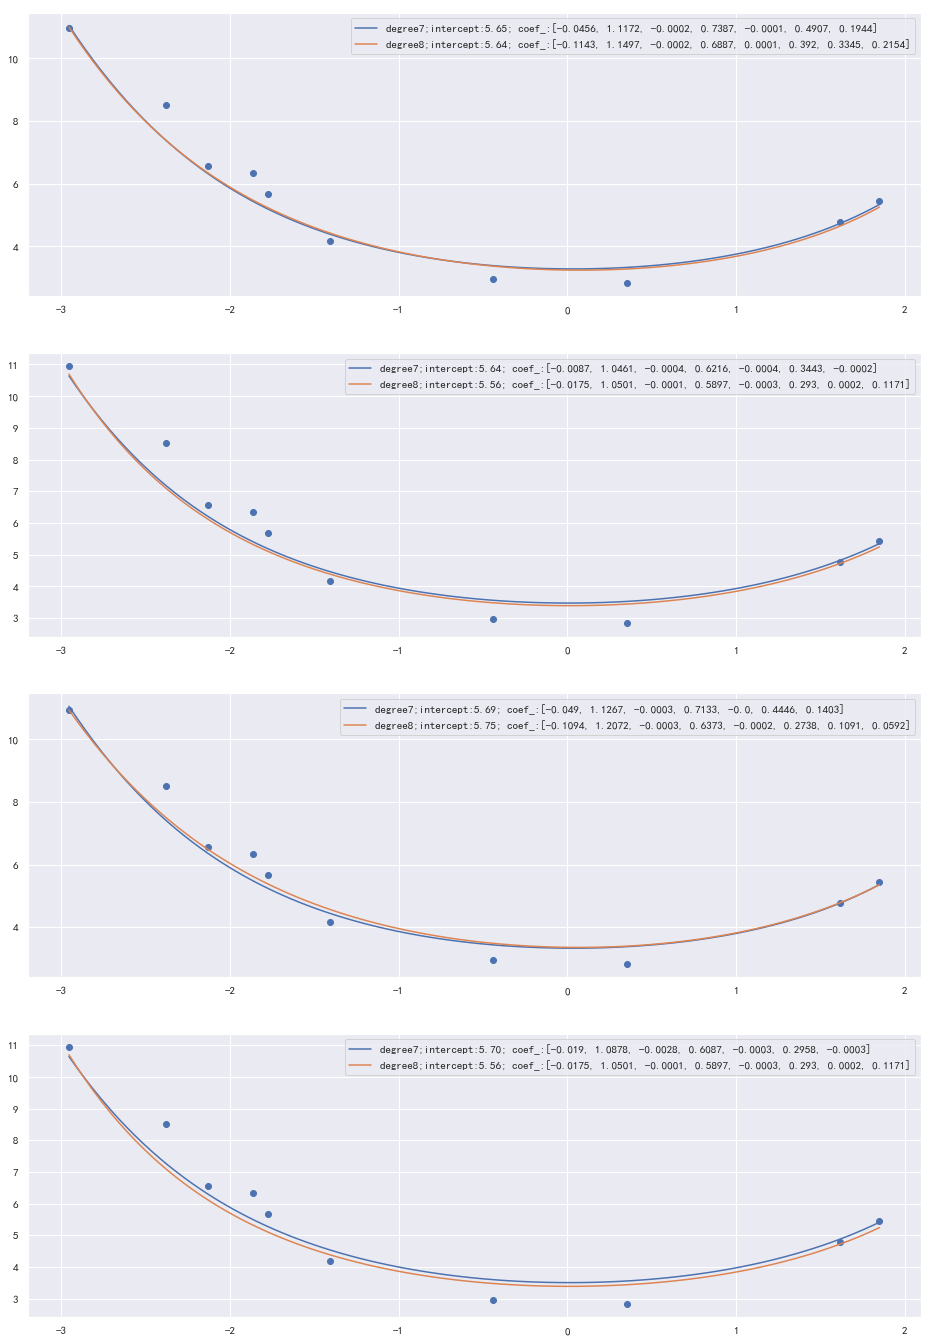

In [200]:
fig, ax = plt.subplots(4, 1, figsize=(16, 6 * 4))

# 权重较小的原因是由于初始化的时候为1
show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.2)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.3)

show_lasso_fig(ax[2], X, y, 7, 8, alpha=0.001, max_iters=1000000,c=0.00000001,lamb=0.2)

show_lasso_fig(ax[3], X, y, 7, 8, alpha=0.001, max_iters=1000000,c=0.00000001,lamb=0.3)

In [202]:
a,b = 0.5, 1
n = 40
X = 10 * np.random.rand(n, 1) - 5 # x的取值范围
y = a * np.square(X) + b * X + 2 + np.random.normal(0,1,size = X.shape)  #y = a*x^2 + b*x + 2
y = y.reshape(y.size)

X.shape, y.shape

((40, 1), (40,))

final cost:0.624407
final cost:0.630956
final cost:0.703998
final cost:0.729090


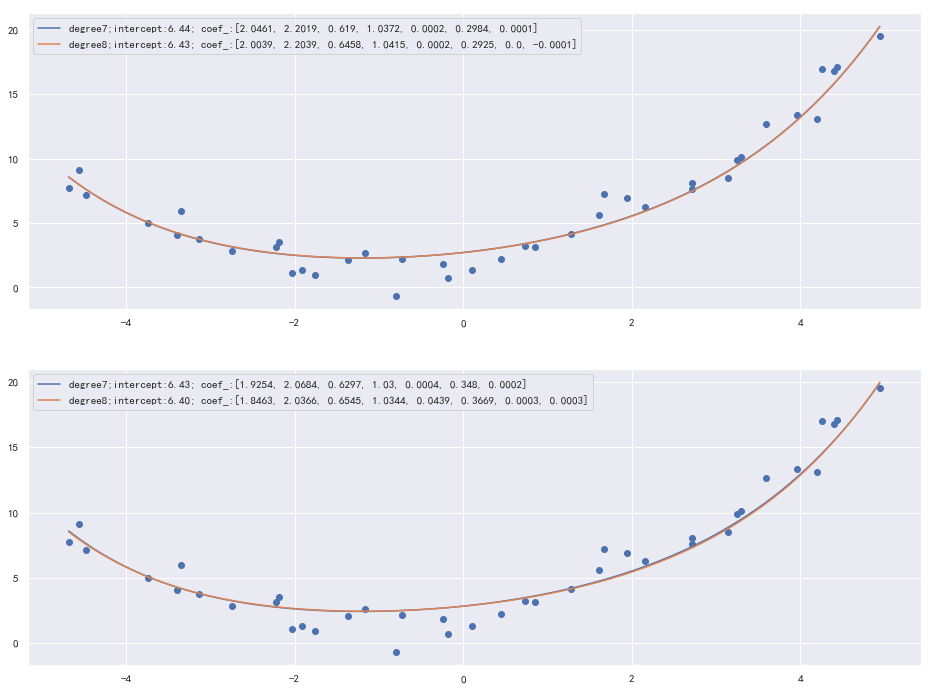

In [203]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.2)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,lamb=0.3)

final cost:0.592338
final cost:0.617071
final cost:1.197924
final cost:1.232611


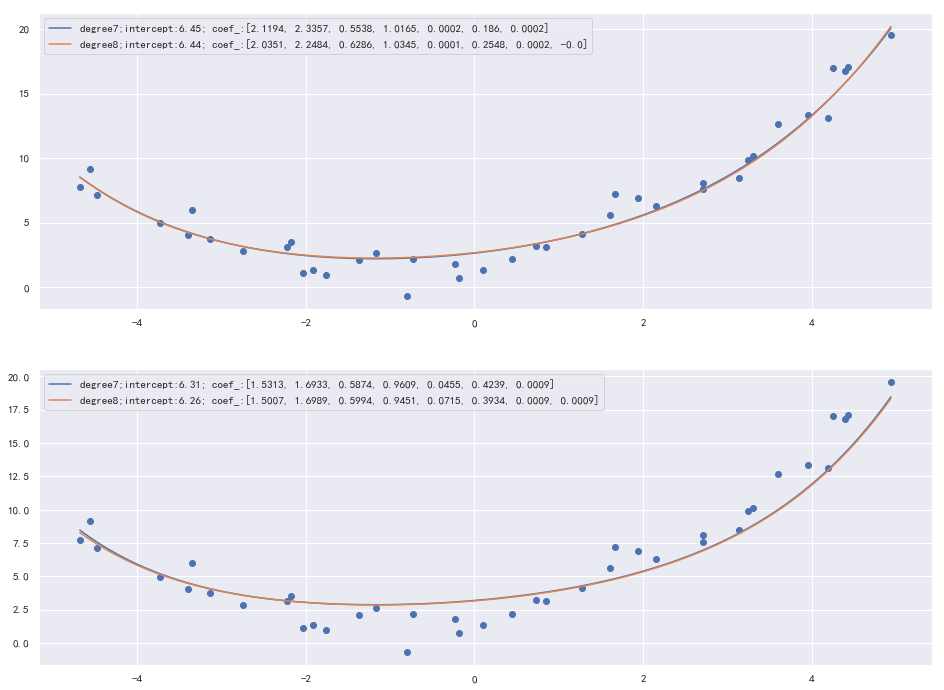

In [208]:
fig, ax = plt.subplots(2, 1, figsize=(16, 6 * 2))

show_lasso_fig(ax[0], X, y, 7, 8, alpha=0.001, max_iters=1000000,c=0.00000001,lamb=0.2)

show_lasso_fig(ax[1], X, y, 7, 8, alpha=0.001, max_iters=1000000,c=0.00000001,lamb=0.7)

### 权重的初始值随机应该比较好
权重的初始值随机应该比较好，不然每次训练出的参数结果都一样。